# Train with video (Multiple Examples)

In [45]:
import torch
torch.cuda.set_device(7)

from experiment.experiment import Experiment
from utils.spatial_utils import PerceptualLoss, SpatialMapsGenerator, BatchGenerator
from models import spatial
from models.skip import skip
from utils.common_utils import (generateSyntheticTexture,
                               generateSyntheticData,
                               preprocessTarget,
                               numpyToVar)
import torch
dtype = torch.cuda.FloatTensor
from IPython.core.display import display, HTML
from models.decoder import decoder
from utils.decoder_utils import SpatialVectorGenerator, MultipleVectorGenerator
from torch.utils import data
import numpy as np

In [149]:
config = {
    "PLOT": True,
    "optimizer": "adam",
    "lr": 1e-3,
    "num_iter": 30000,
    "show_every": 100,
    "maps_number": 4,
    "pic_code_size": 300,
    "time_code_size": 4,
    "output_size": 128,
    "video_length": 64,
    "examples": 30,
    "batch_size": 4,
    "reg_noise": 0.01
}

config["input_size"] = config["pic_code_size"] + config["time_code_size"]
config['net_params'] = {"input_size": config['input_size'], "num_channels_up": [32, 32, 32]}

In [150]:
net = decoder(**config["net_params"])
net = net.cuda()

videos = []
for i in range(config["examples"]):
    videos.append(generateSyntheticTexture(random=True, seed=i)[:64])


target = preprocessTarget(np.concatenate(videos), config["video_length"] * config["examples"], config["output_size"])
loss = PerceptualLoss()
multiple_maps_generator = MultipleVectorGenerator(config['time_code_size'], 
                                                 config['pic_code_size'], 
                                                 n_examples=config['examples'], 
                                                 video_length=config['video_length'])

batch_generator = BatchGenerator(target, multiple_maps_generator, config[
                                 "input_size"], config["input_size"], config["batch_size"])

parameters = list(net.parameters())

for spatial_maps_generator in multiple_maps_generator.code_generators:
    parameters.append(spatial_maps_generator.variables_['picture'])
parameters.append(multiple_maps_generator.code_generators[0].variables_['time_delta'])
parameters.append(multiple_maps_generator.code_generators[0].variables_['time_gamma'])

train_with_video = Experiment(config, parameters, batch_generator, net, loss)

Starting optimization with ADAM


/home/aafilatov/Images2Life/experiment/experiment.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  (i, total_loss.data[0]), '\r', end='')


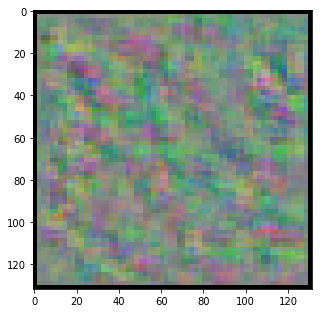

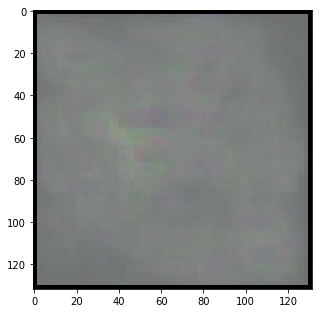

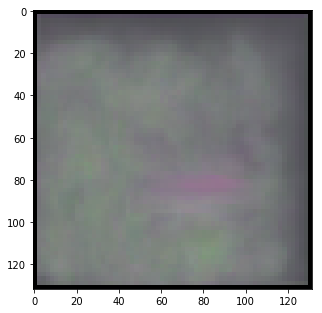

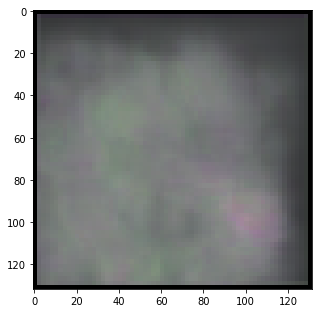

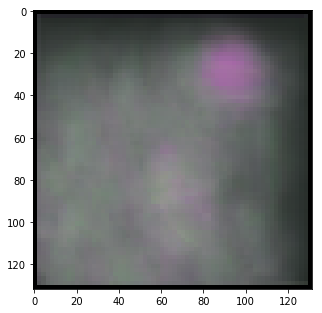

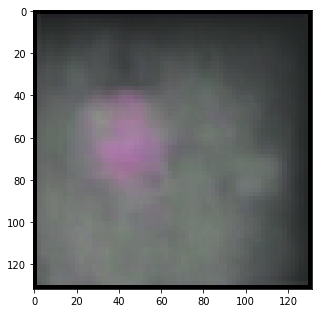

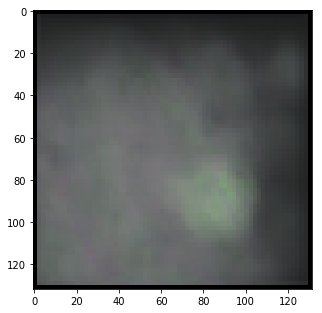

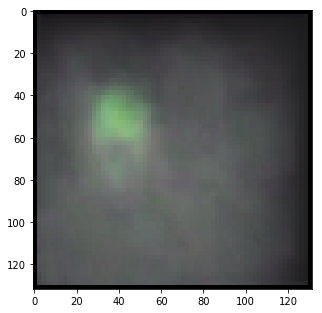

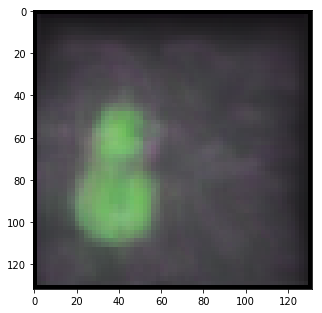

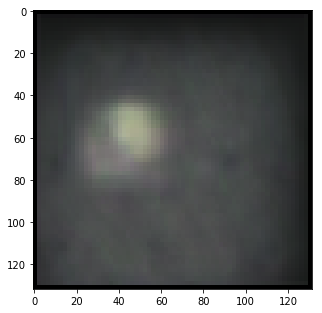

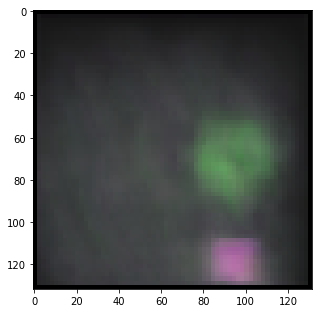

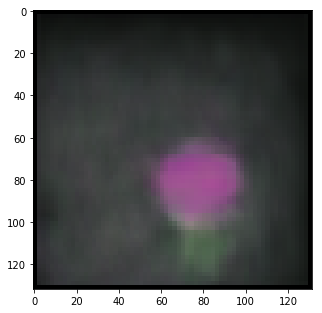

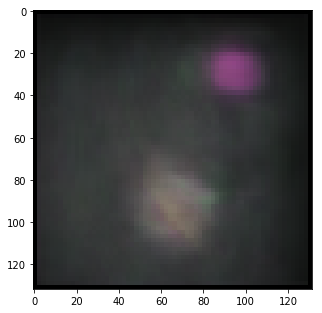

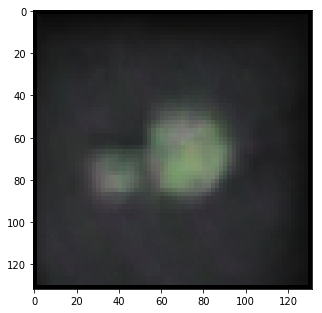

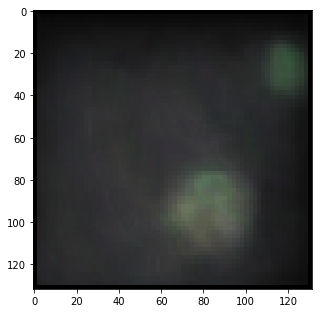

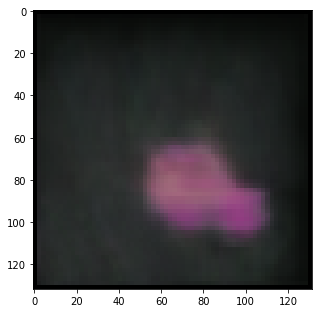

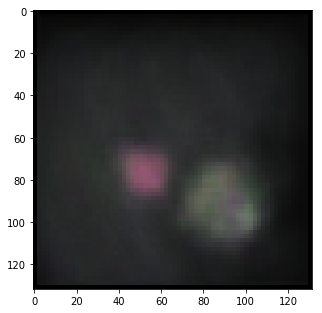

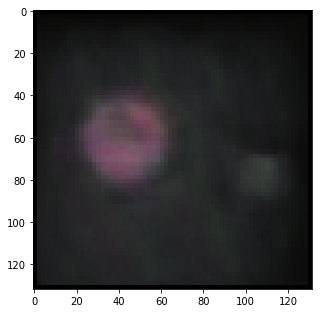

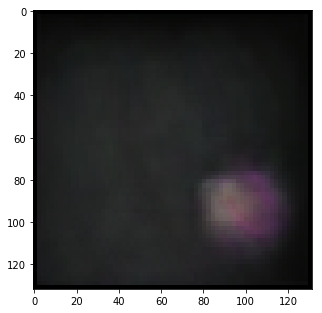

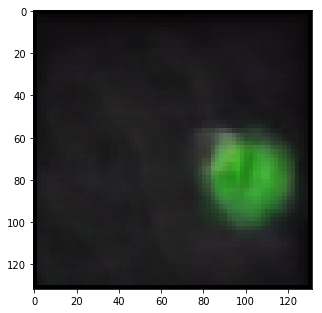

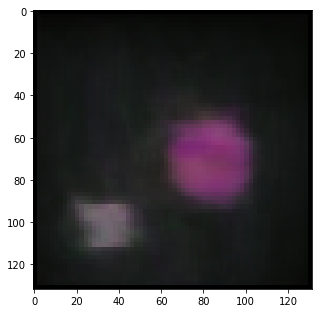

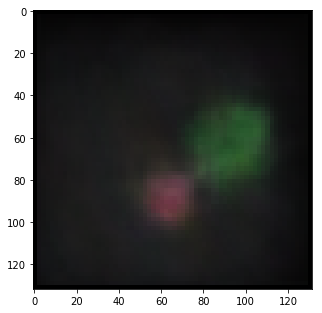

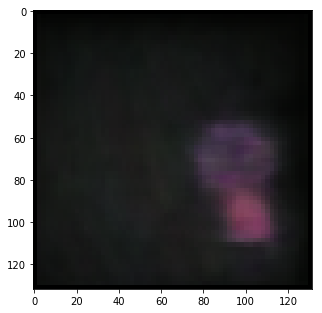

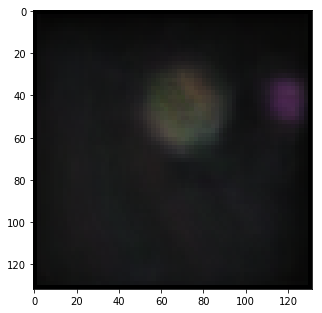

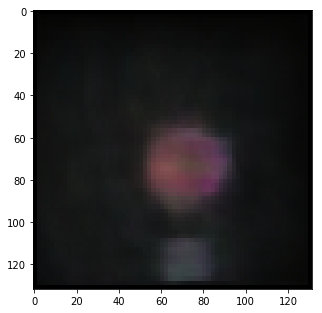

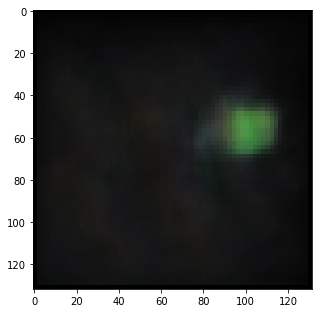

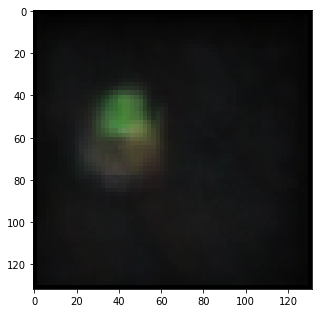

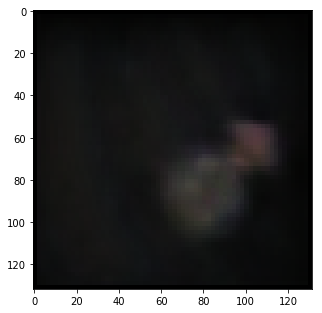

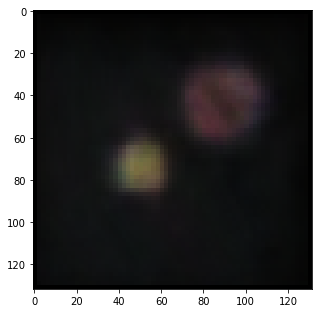

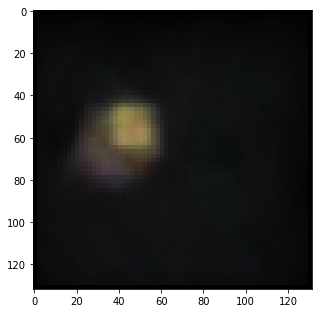

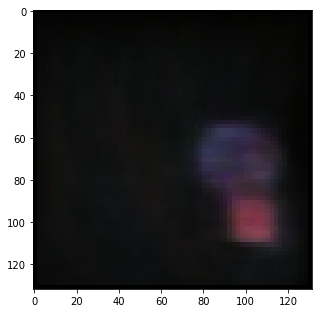

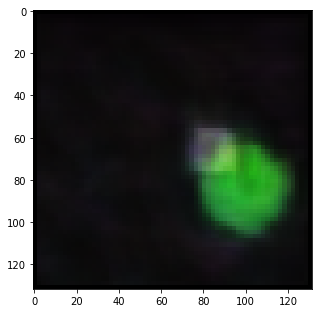

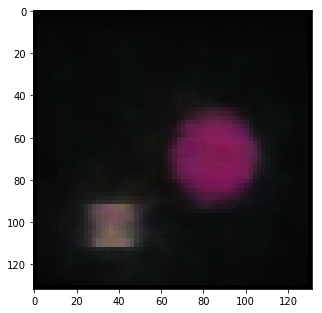

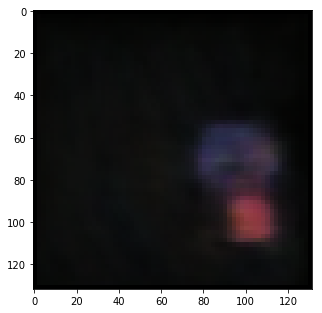

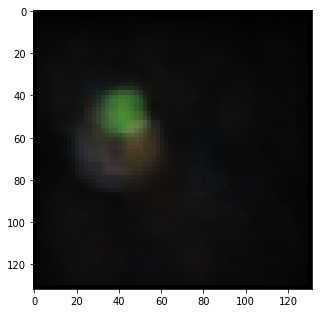

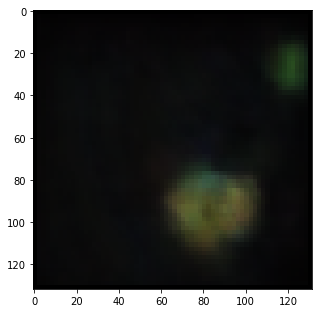

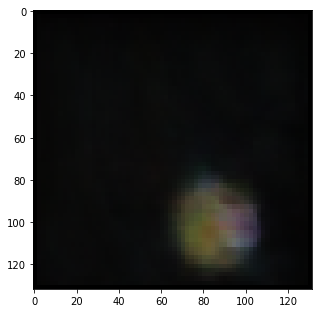

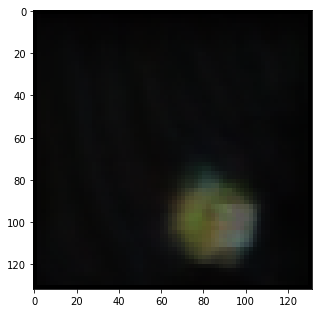

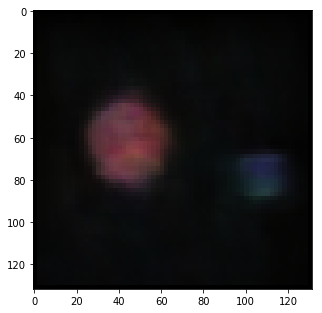

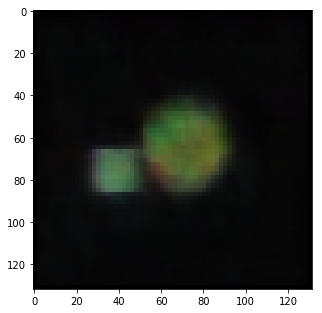

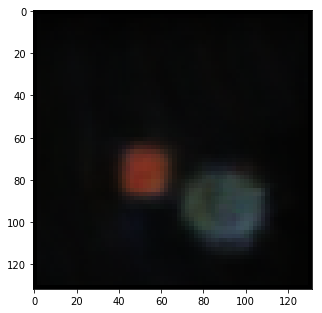

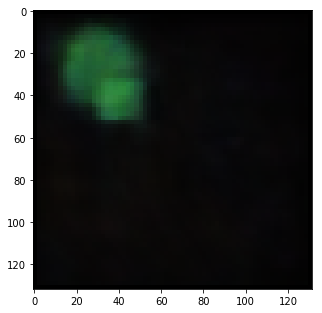

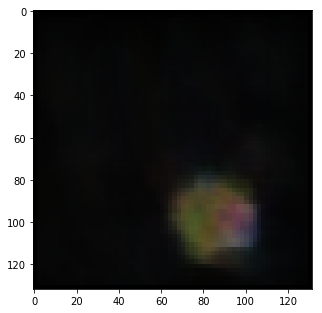

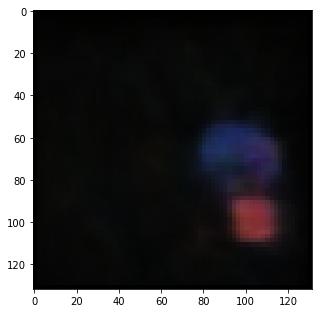

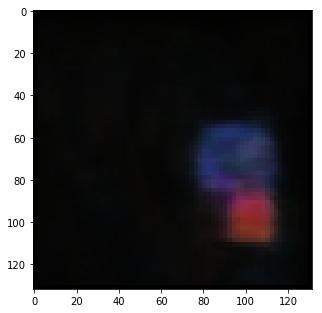

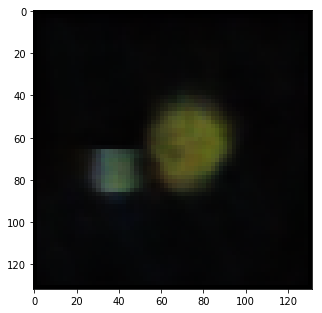

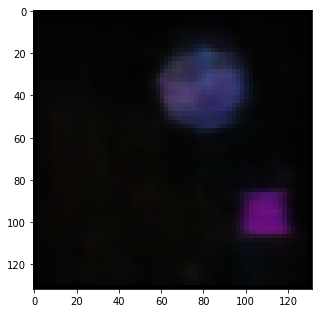

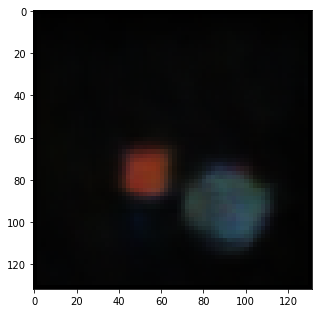

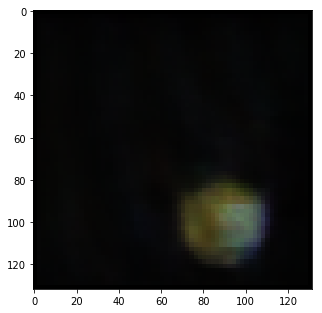

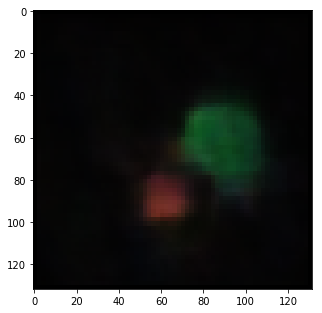

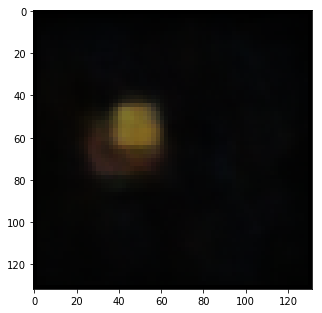

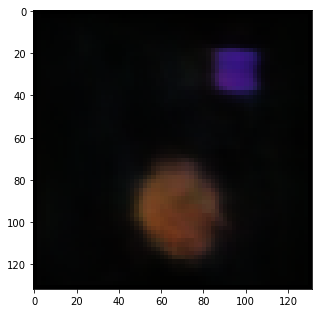

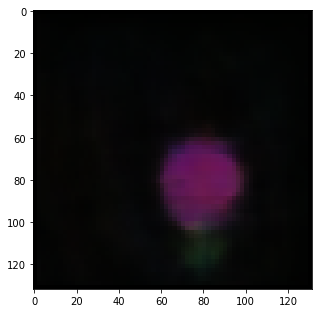

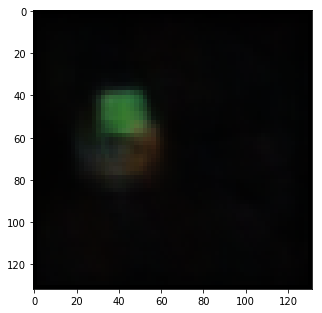

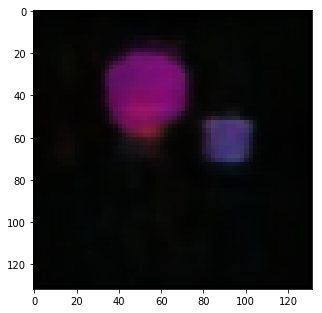

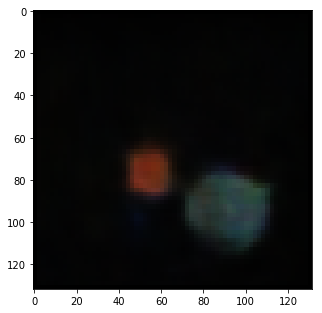

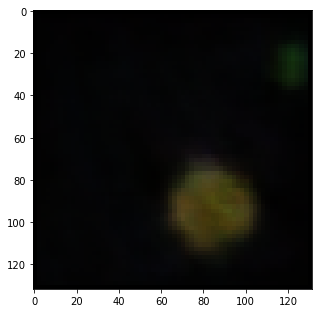

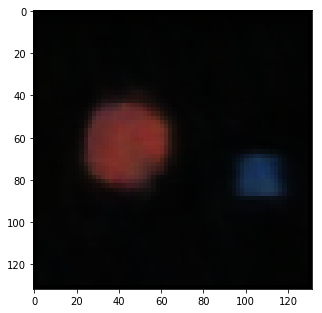

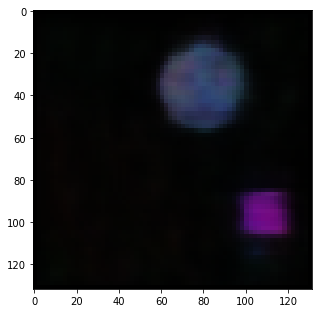

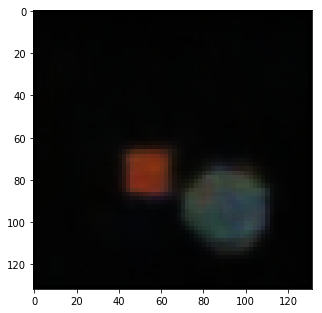

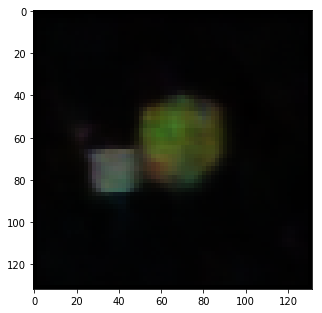

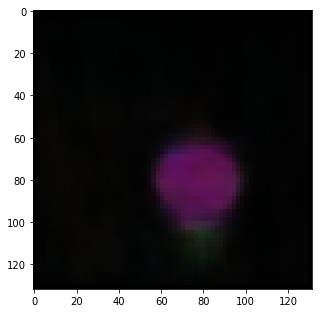

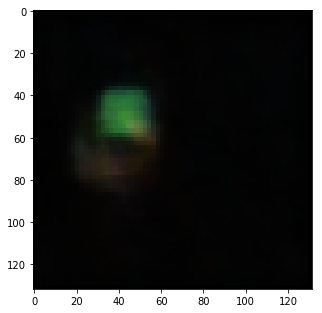

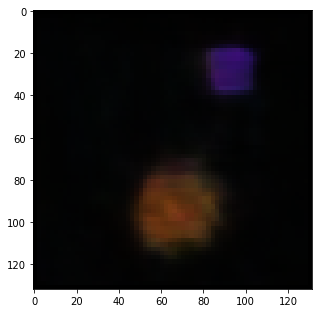

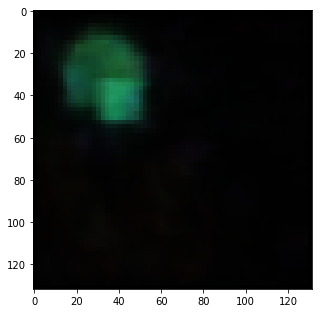

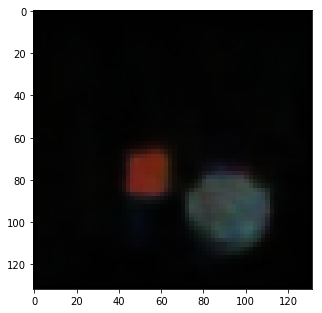

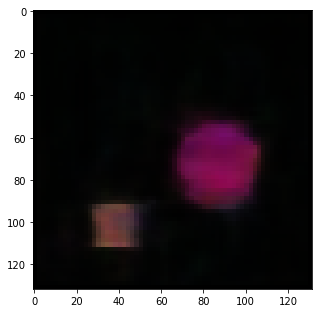

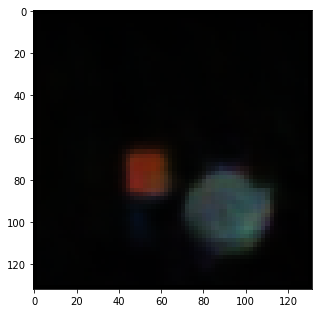

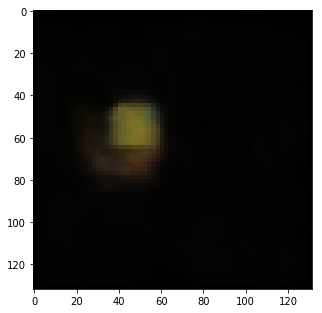

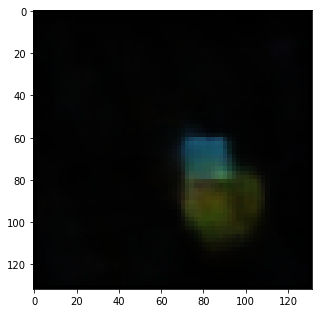

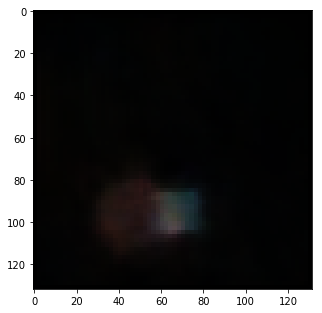

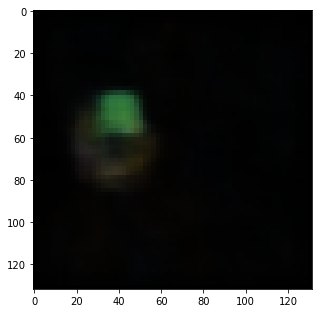

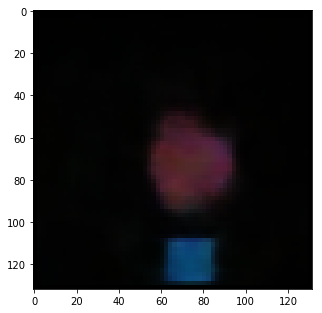

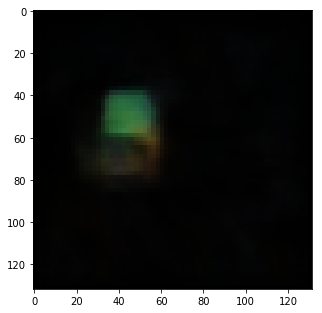

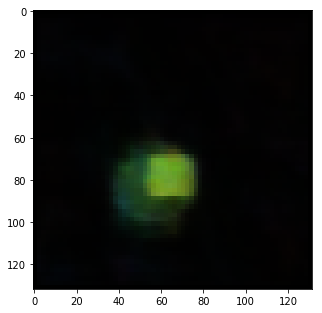

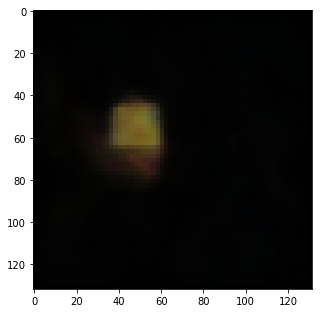

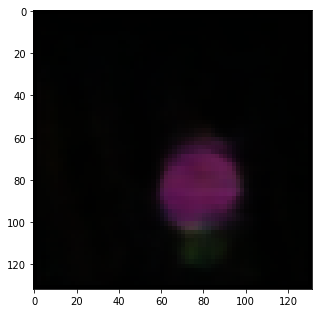

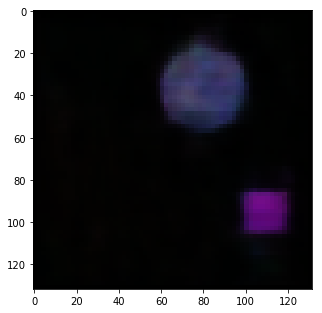

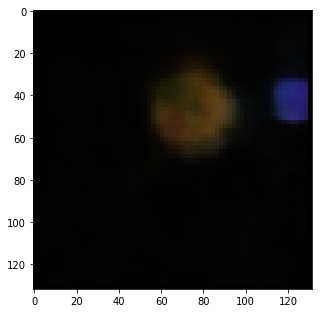

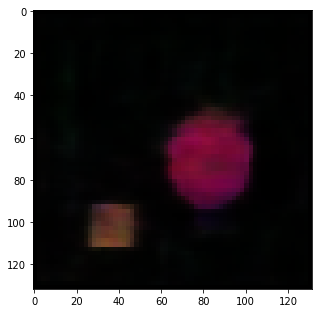

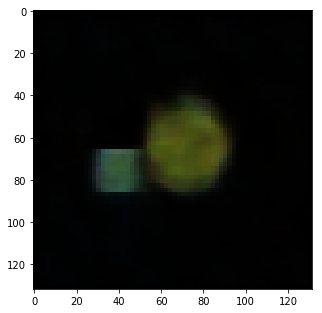

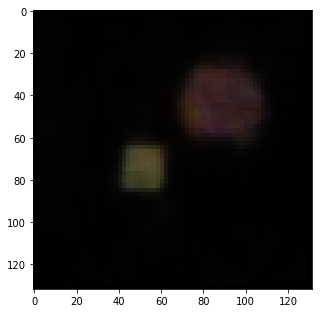

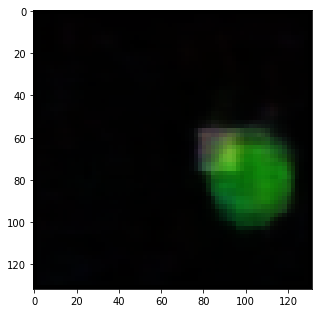

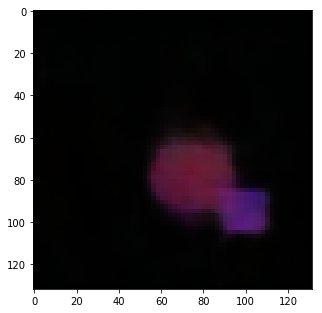

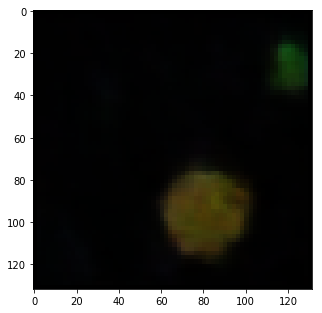

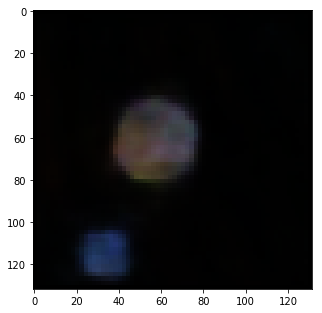

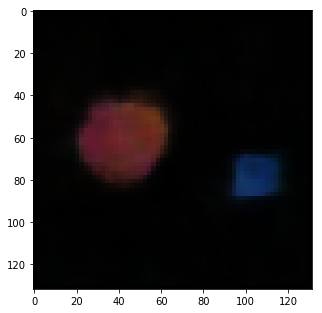

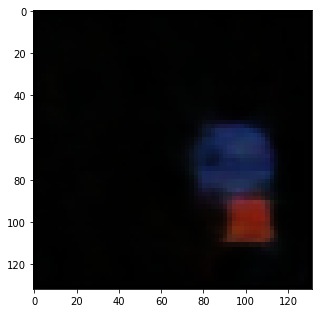

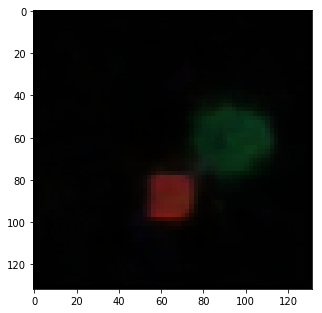

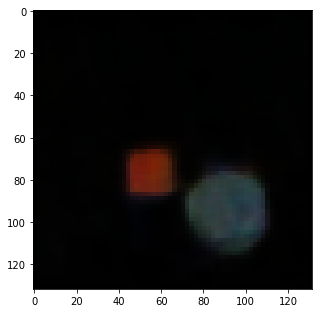

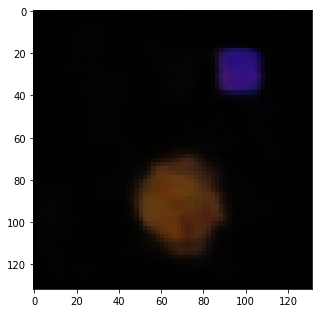

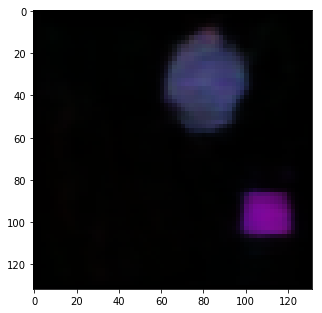

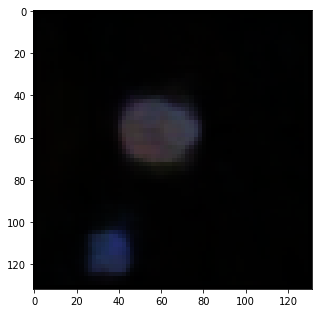

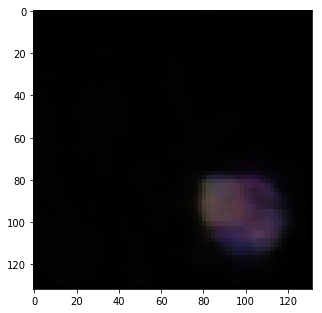

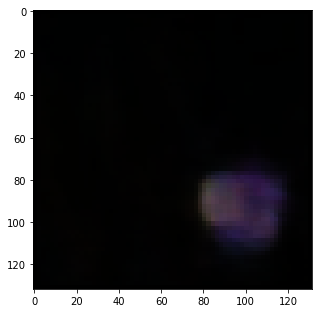

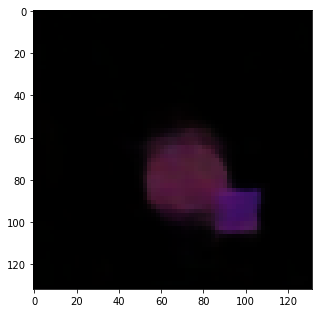

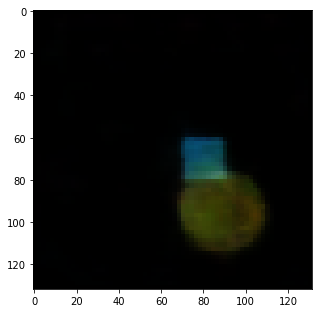

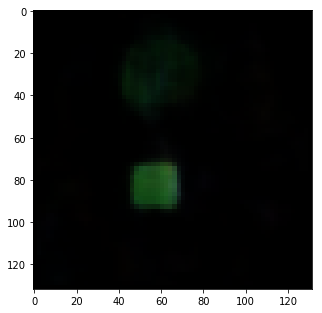

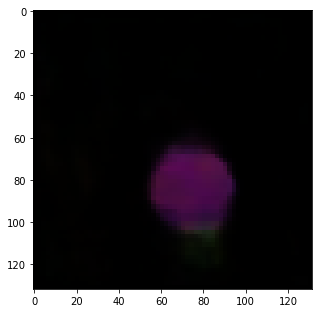

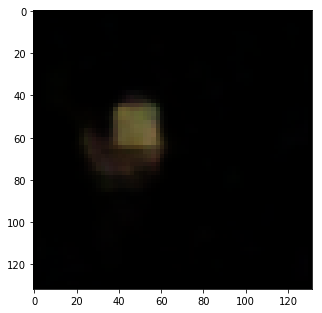

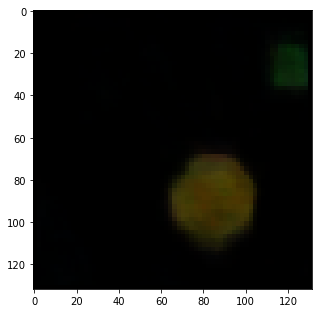

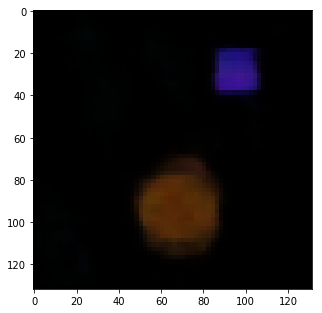

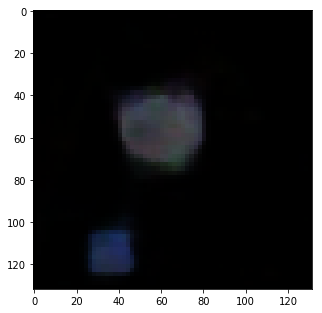

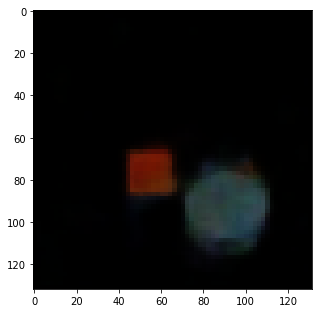

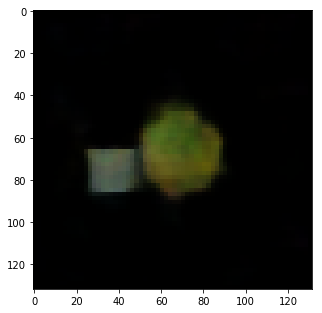

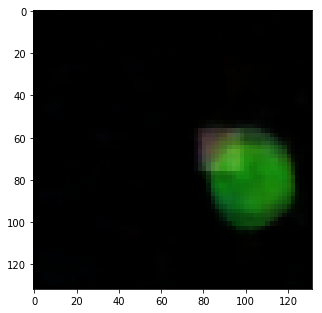

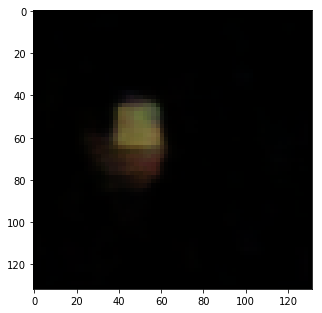

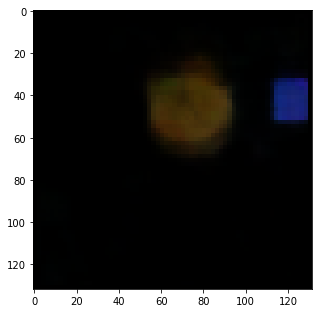

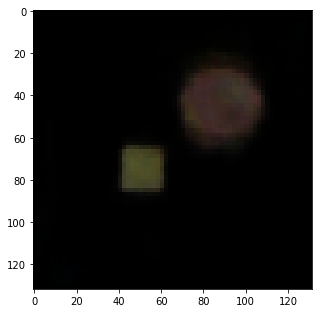

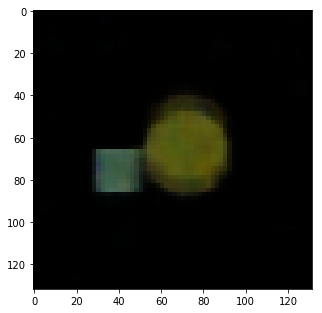

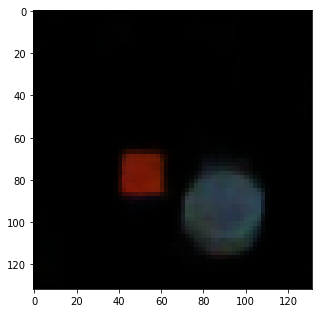

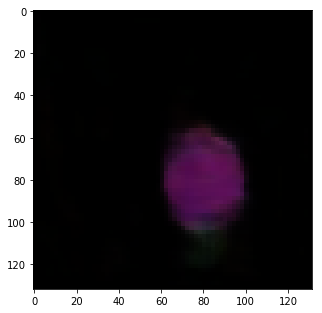

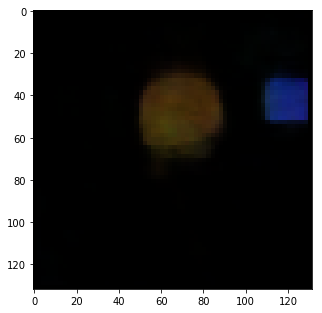

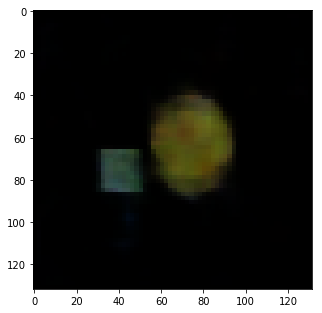

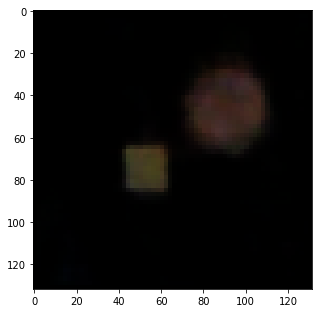

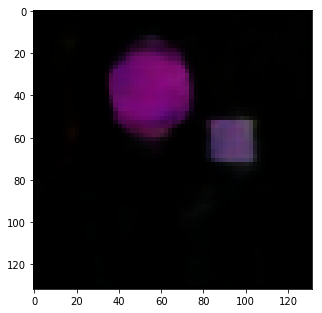

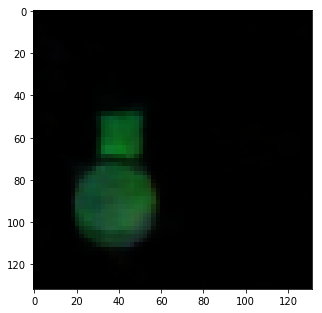

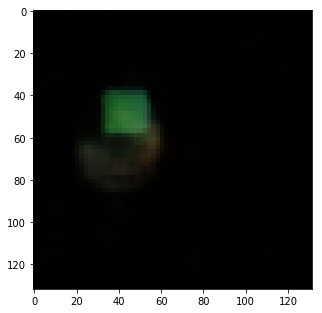

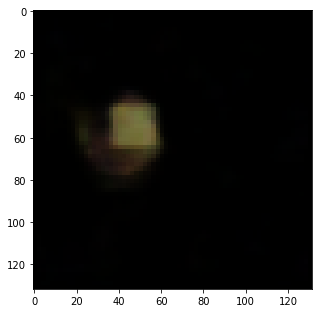

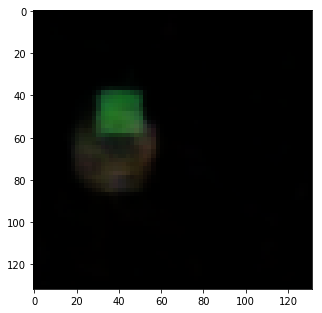

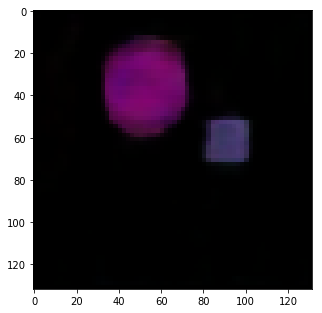

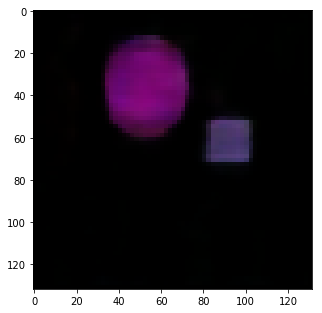

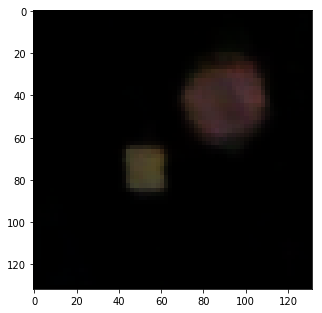

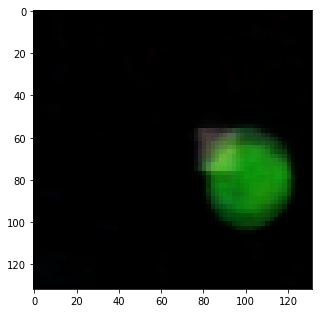

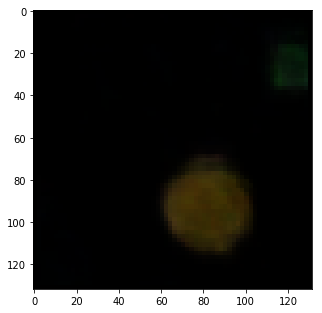

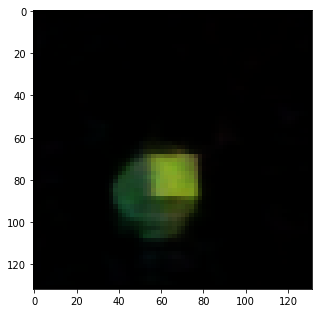

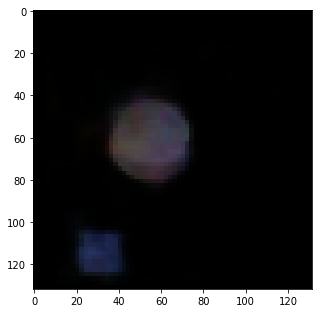

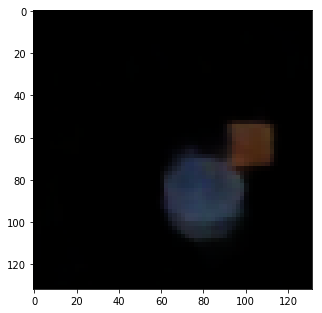

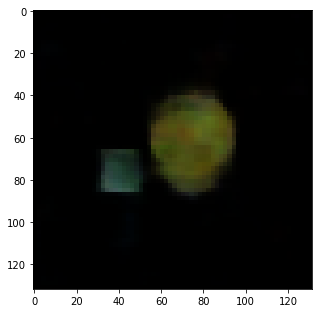

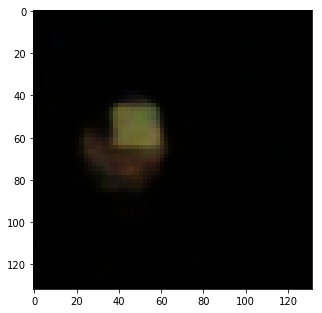

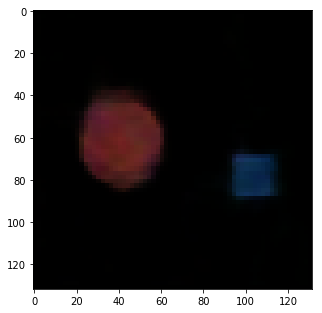

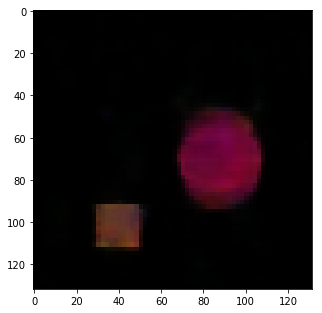

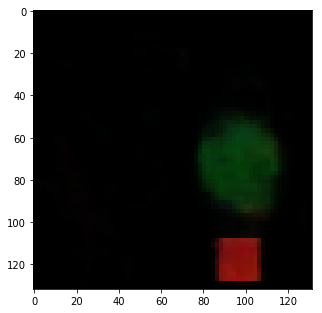

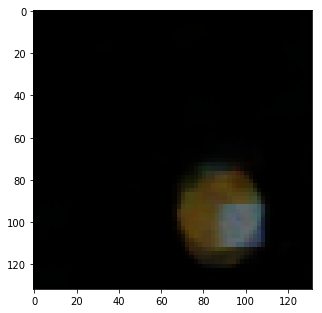

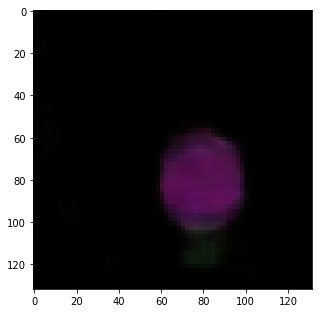

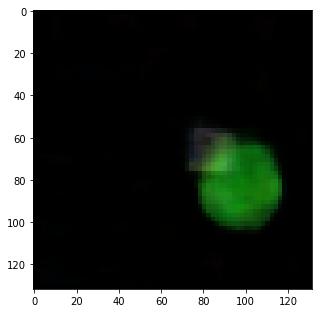

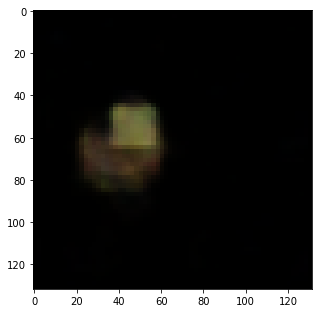

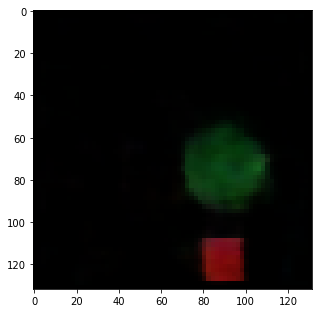

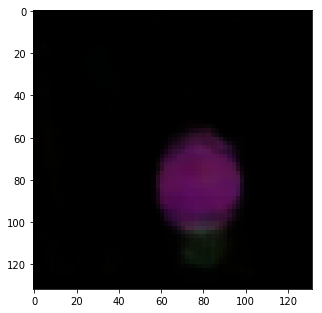

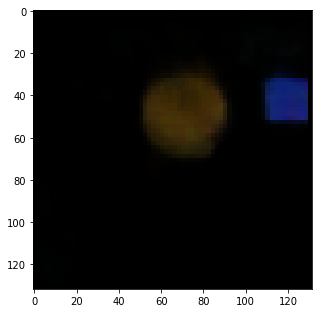

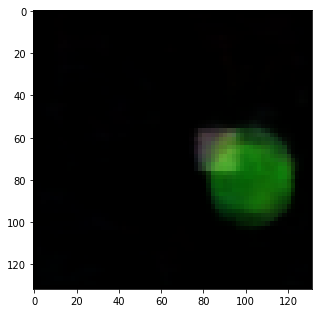

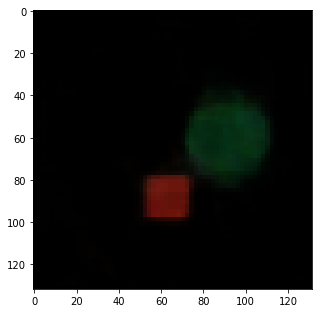

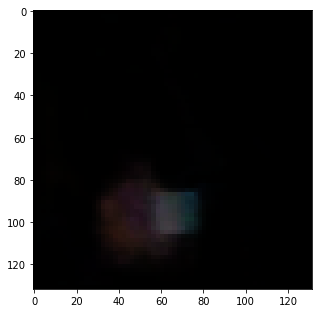

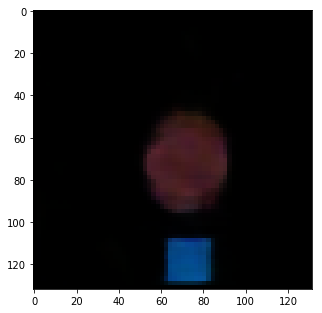

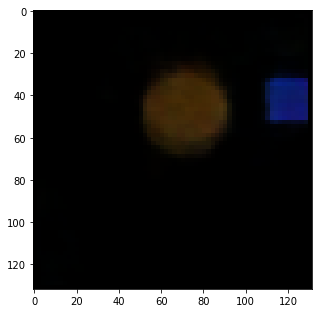

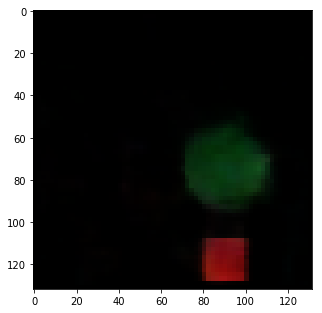

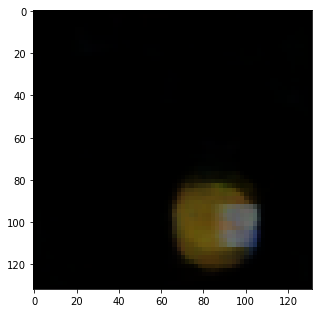

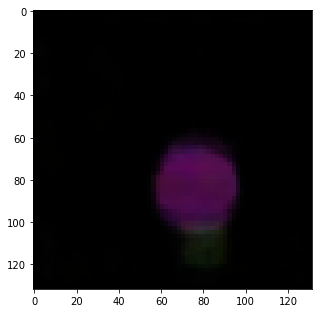

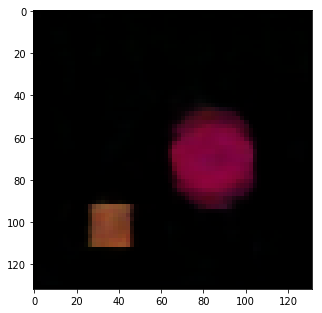

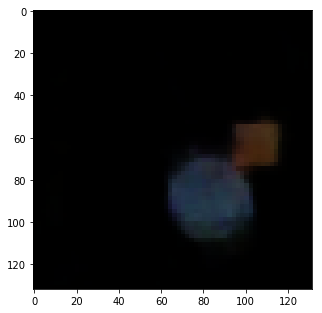

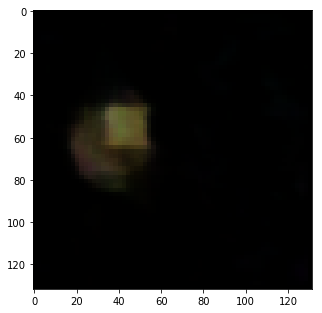

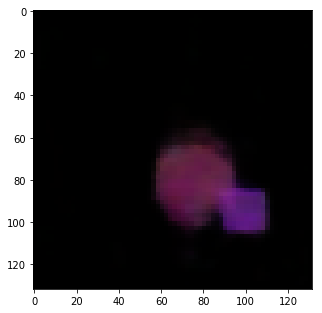

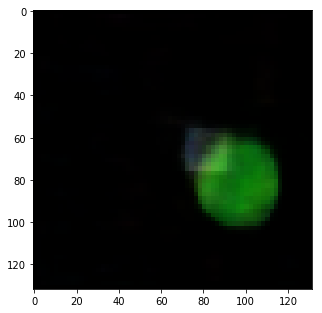

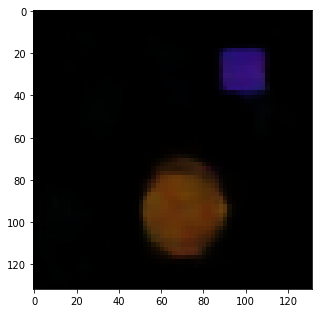

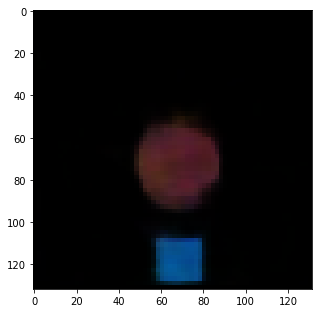

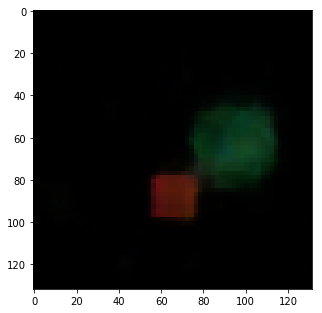

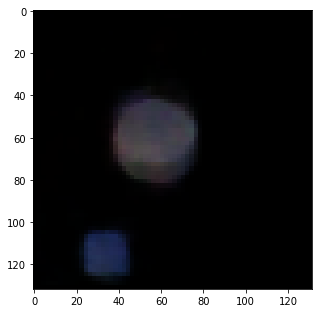

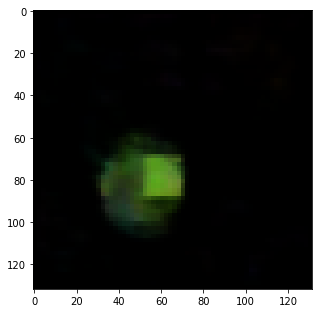

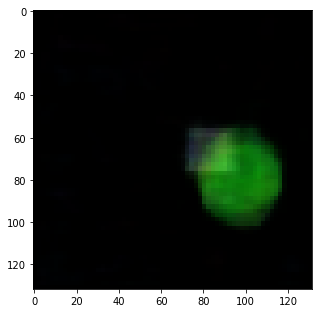

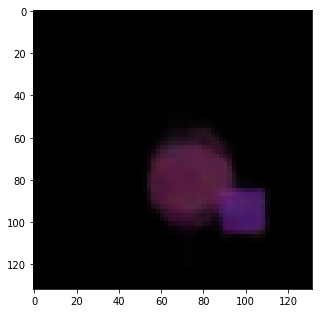

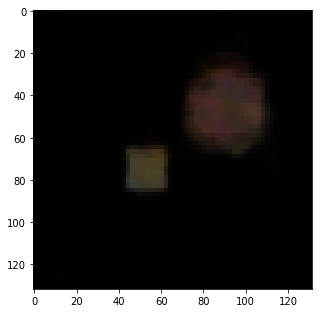

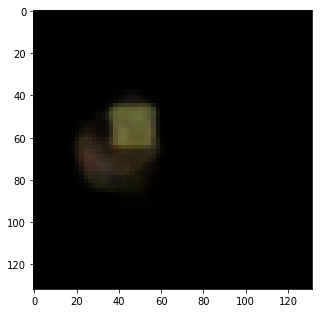

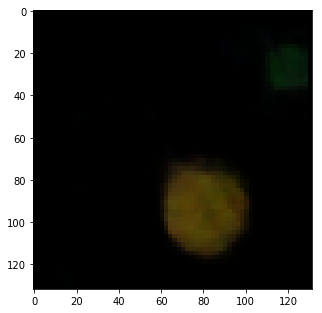

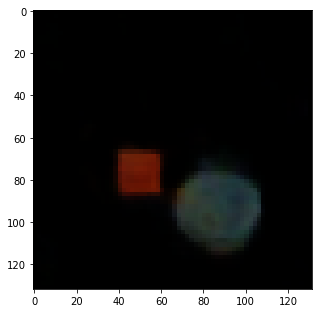

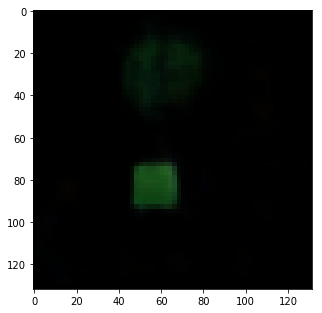

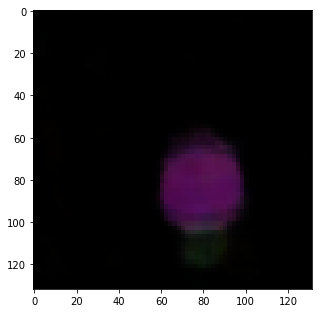

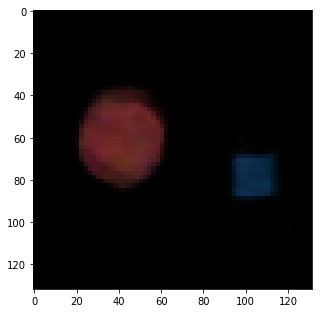

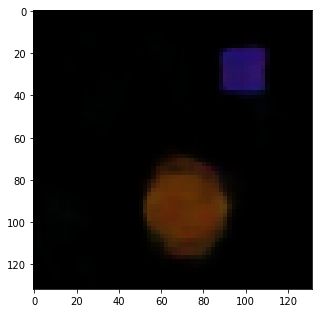

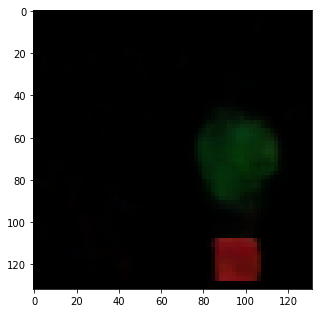

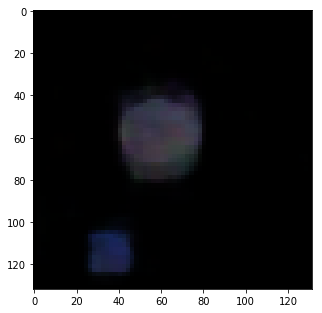

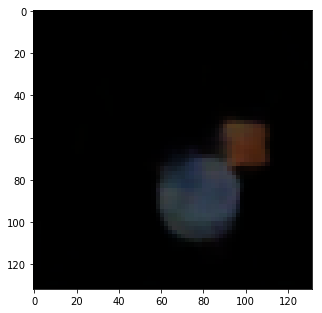

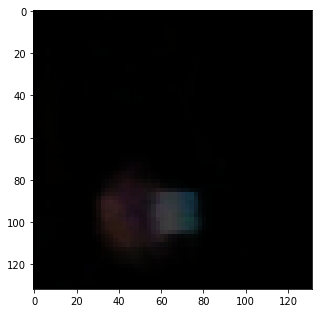

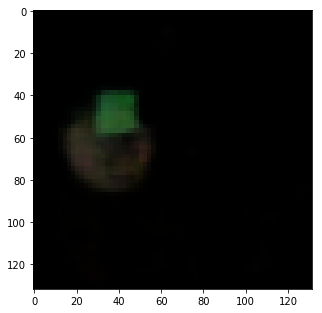

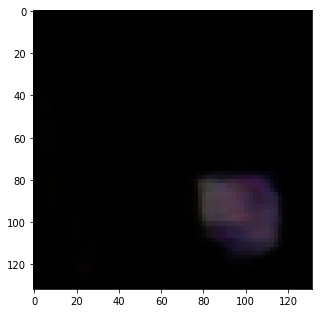

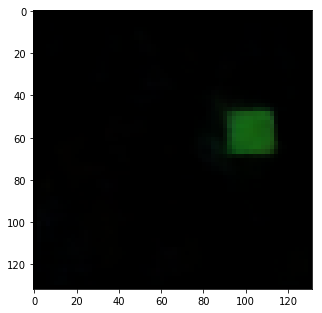

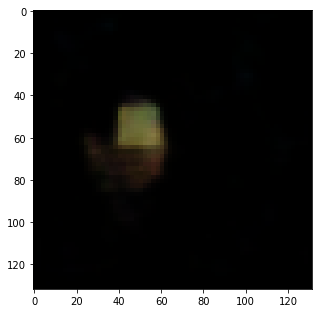

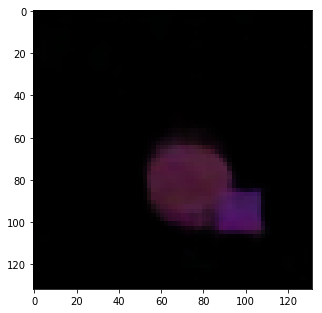

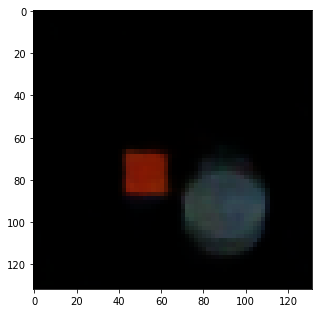

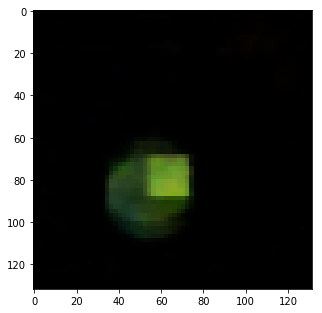

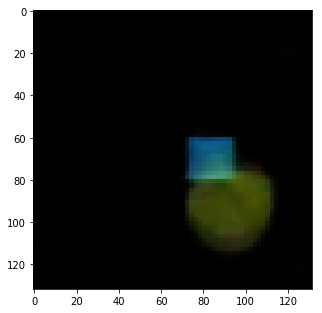

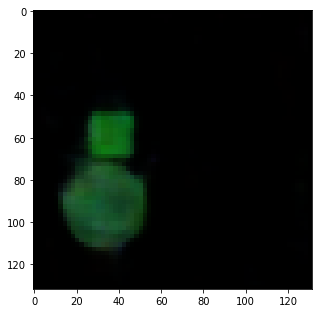

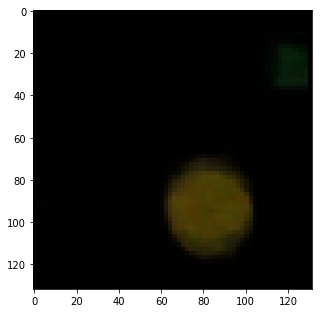

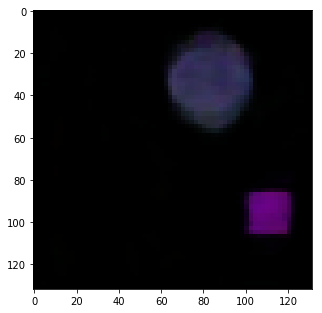

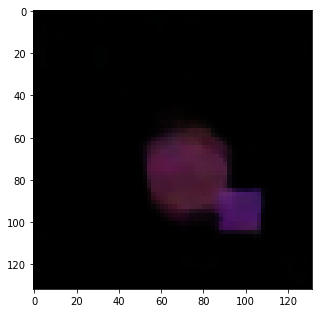

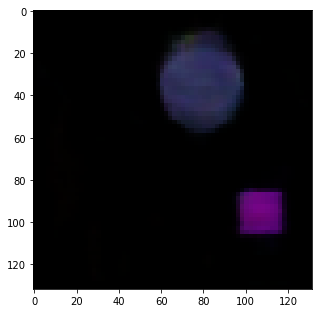

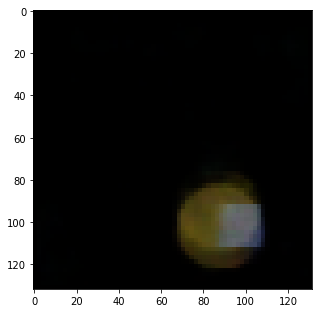

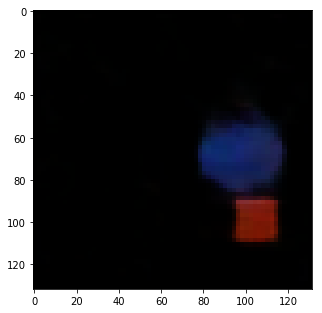

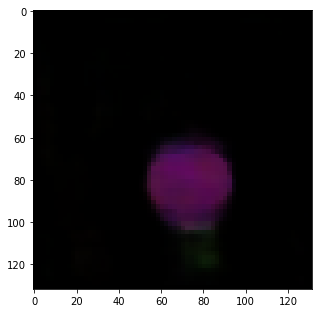

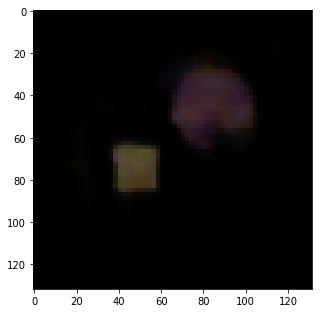

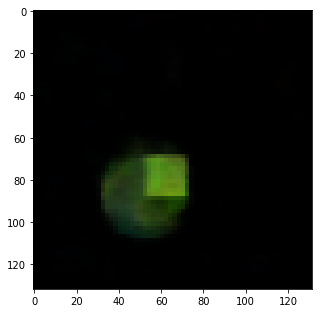

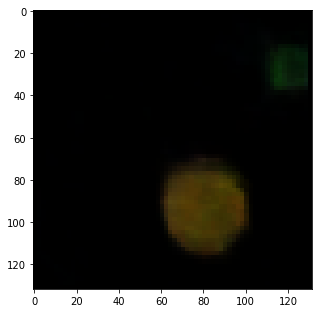

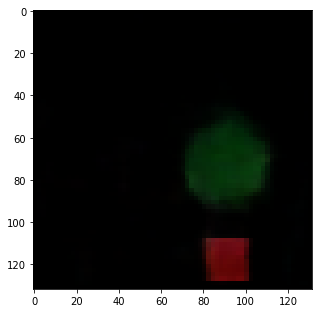

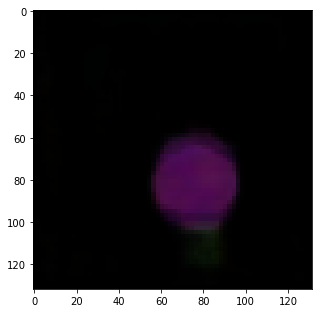

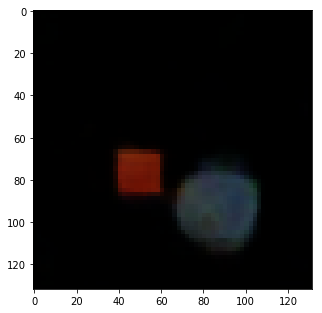

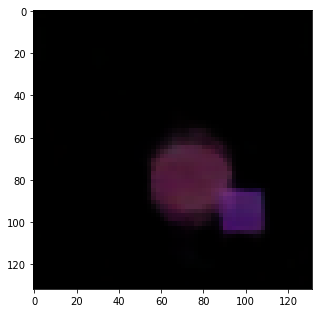

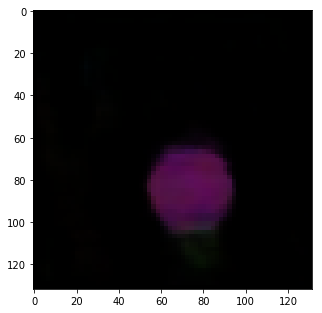

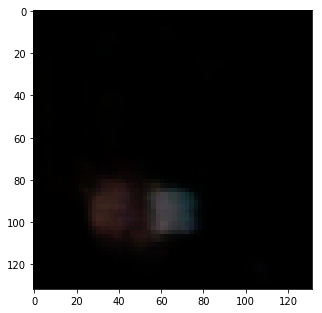

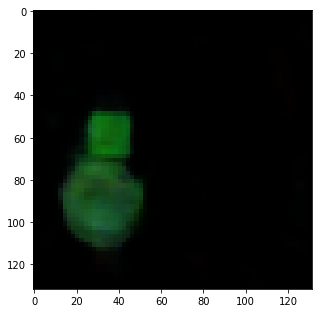

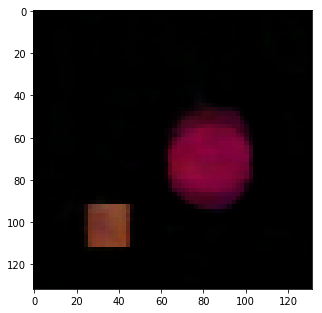

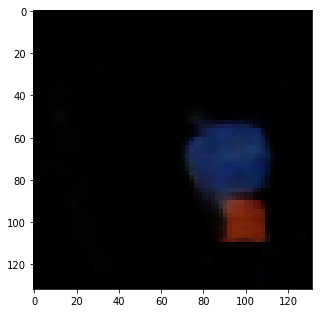

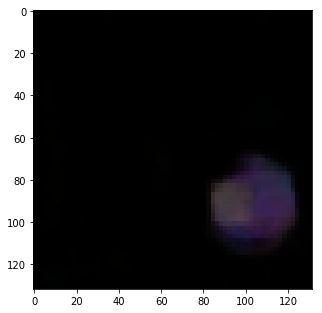

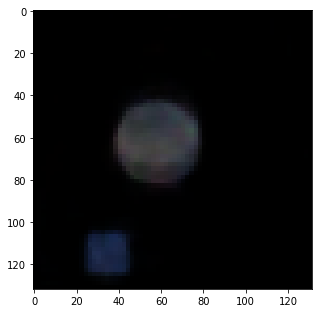

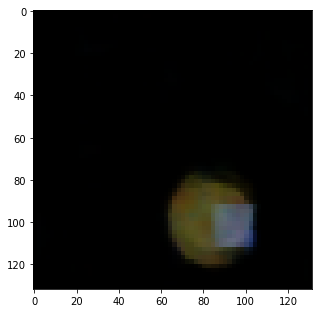

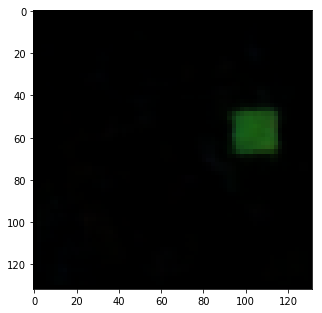

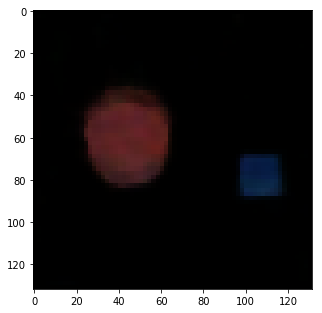

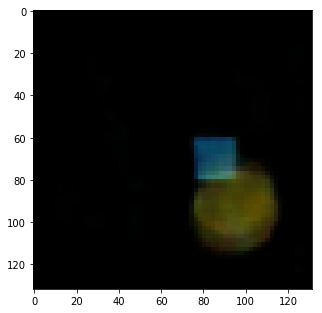

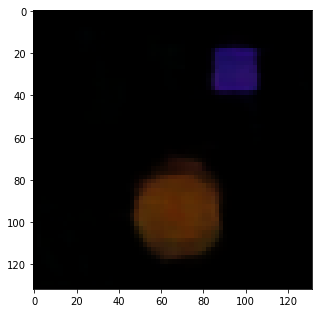

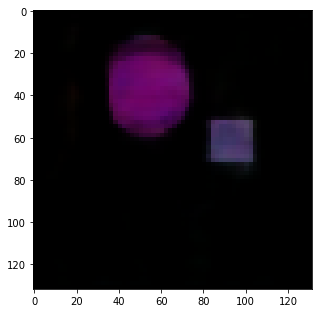

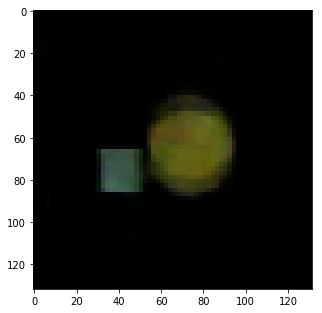

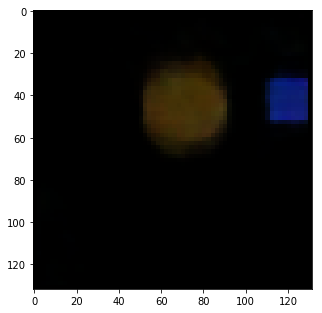

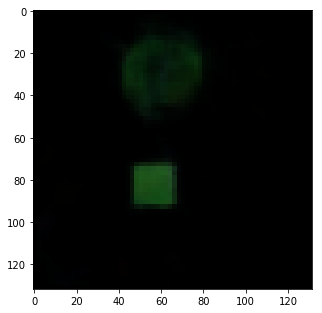

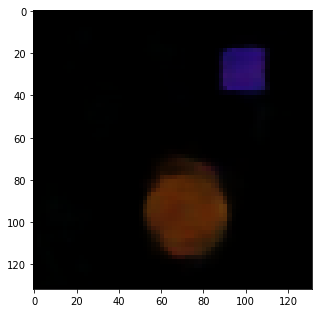

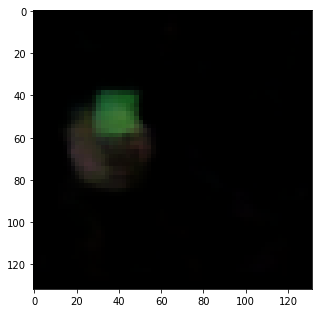

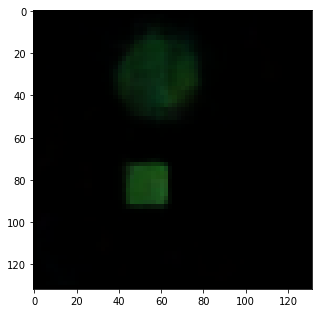

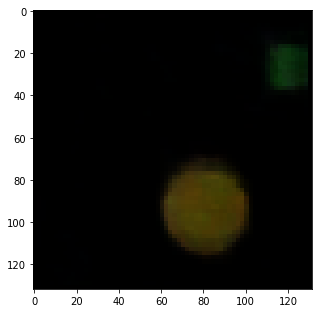

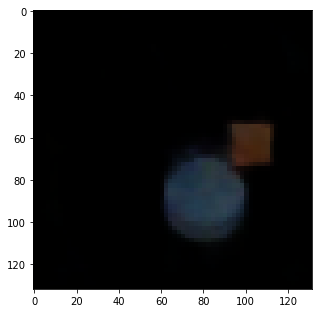

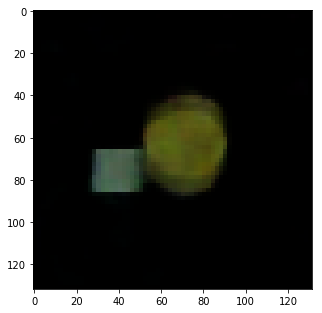

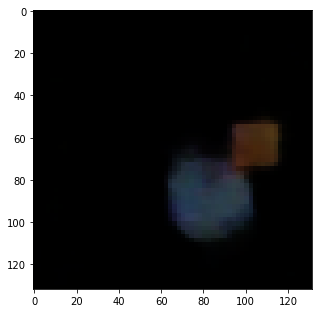

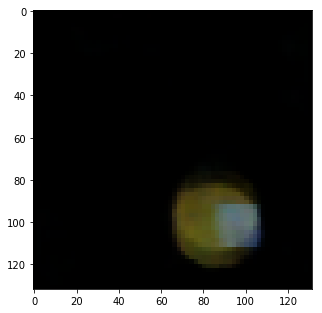

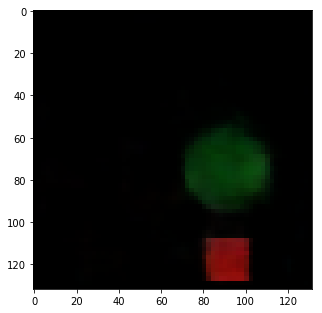

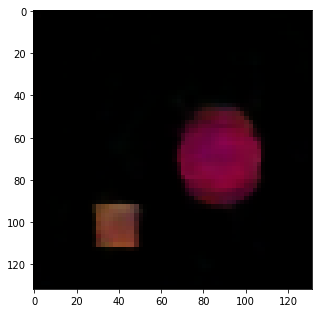

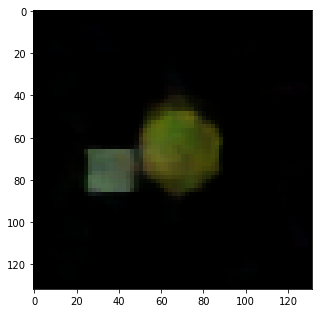

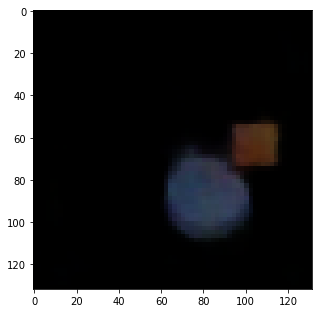

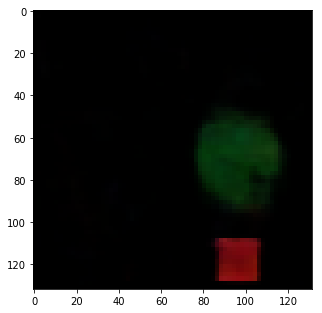

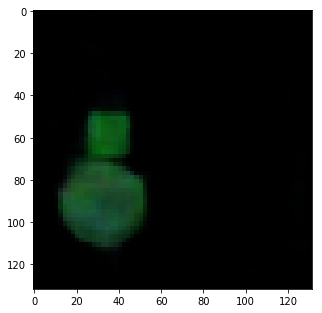

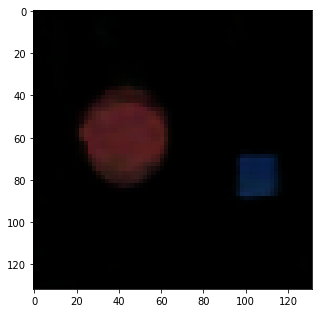

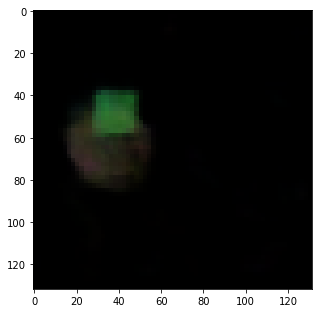

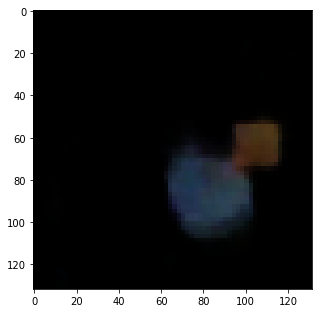

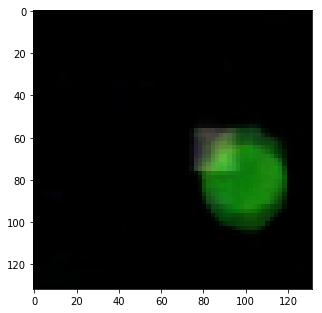

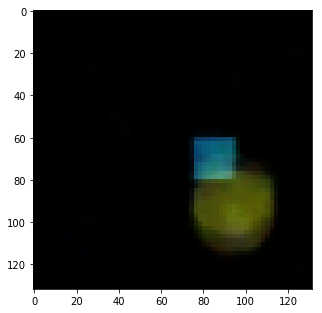

In [151]:
train_with_video.run()

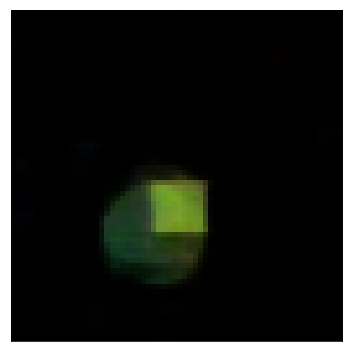

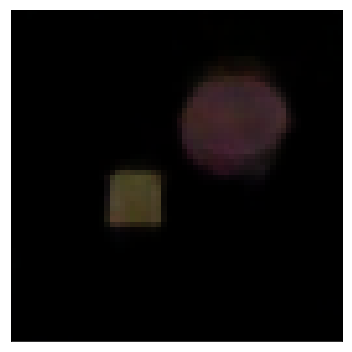

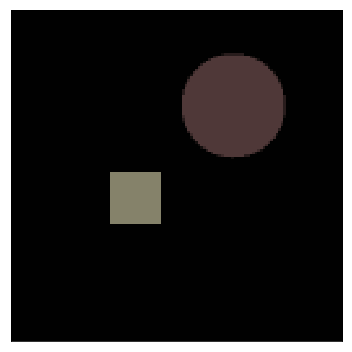

In [152]:
train_with_video.save_result();

In [153]:
from IPython.core.display import display, HTML
display(HTML(''' <video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video> '''.format(train_with_video.path_ +"/fit.mp4",
                    train_with_video.path_ +"/predict.mp4",
                    train_with_video.path_ +"/target.mp4")))

In [154]:
#torch.save(net.state_dict(), train_with_video.path_ + '/net_state.dict')
#for key in spatial_maps_generator.variables_:
#    torch.save(spatial_maps_generator.variables_[key], train_with_video.path_ + '/{}.dict'.format(key))

# Train with picture

In [155]:
from utils.common_utils import plotCircle, plotRectangle
import numpy as np

back_side = np.zeros((256, 256, 3))
image = plotCircle(back_side, vertex=(50, 100), size=40, color=(0.3, 0.5, 0.2))
image = plotRectangle(image, vertex=(200, 40), size=30, color=(0.7, 0.1, 0.1))
image = np.array([image, image])

pic_config = {
    "PLOT": True,
    "optimizer": "adam",
    "lr": 1e-3,
    "num_iter": 2000,
    "show_every": 100,
    "maps_number": 4,
    "input_size": config['input_size'],
    "output_size": 128,
    "video_length": 2,
    "batch_size": 2,
    "examples": 1,
}

one_map_generator = MultipleVectorGenerator(config['time_code_size'], 
                                            config['pic_code_size'], 
                                            n_examples=pic_config['examples'], 
                                            video_length=pic_config['video_length'])

one_map_generator.code_generators[0].variables_['time_delta'] = multiple_maps_generator.code_generators[0].variables_['time_delta'].clone()
one_map_generator.code_generators[0].variables_['time_gamma'] = multiple_maps_generator.code_generators[0].variables_['time_gamma'].clone()

target = preprocessTarget(image, pic_config["video_length"], pic_config["output_size"])
batch_generator = BatchGenerator(target, one_map_generator, pic_config[
                                 "input_size"], pic_config["input_size"], pic_config["batch_size"])

parameters = [one_map_generator.code_generators[0].variables_['picture']]
train_with_picture = Experiment(pic_config, parameters, batch_generator, net, loss)

Starting optimization with ADAM


/home/aafilatov/Images2Life/experiment/experiment.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  (i, total_loss.data[0]), '\r', end='')


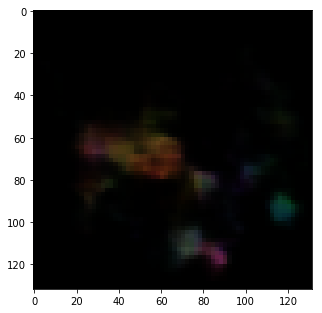

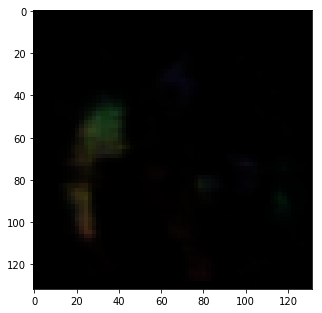

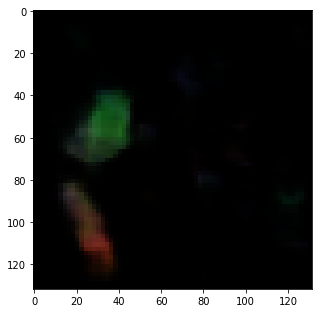

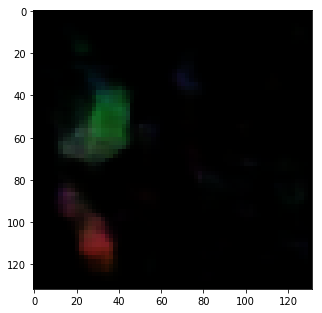

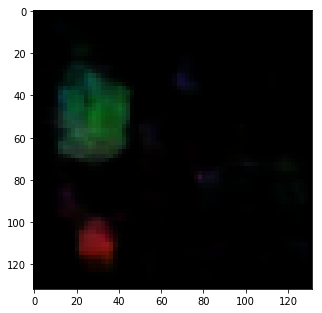

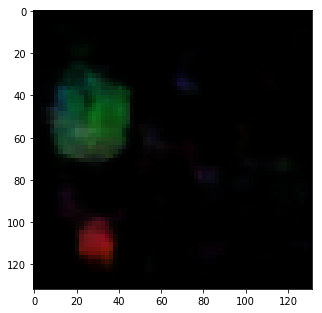

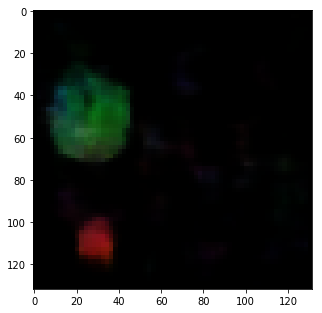

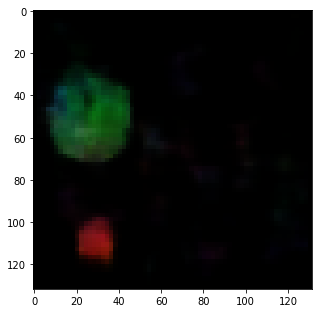

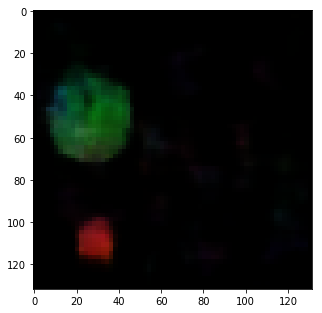

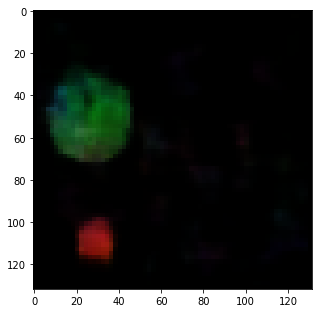

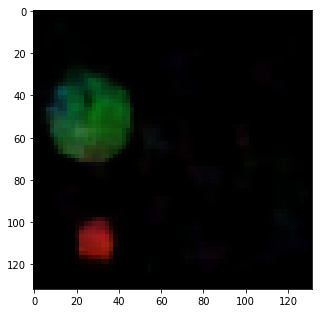

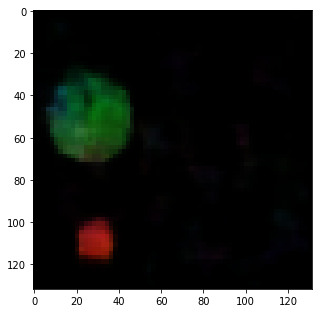

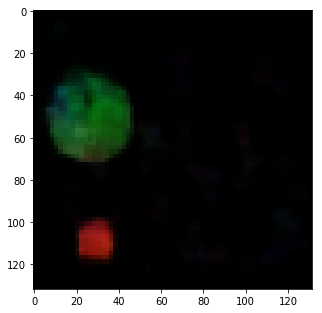

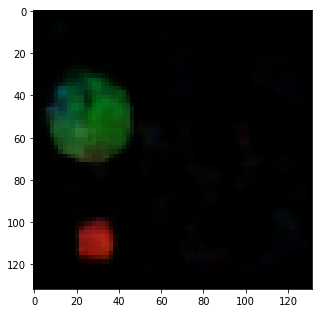

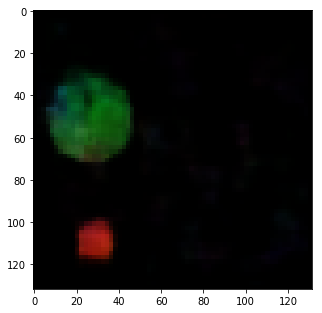

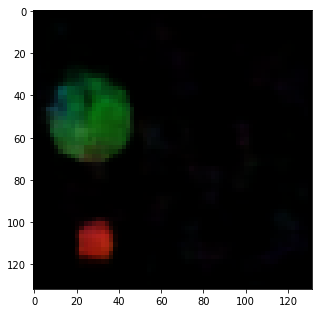

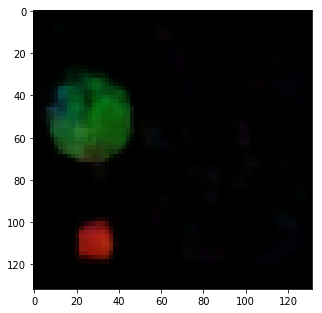

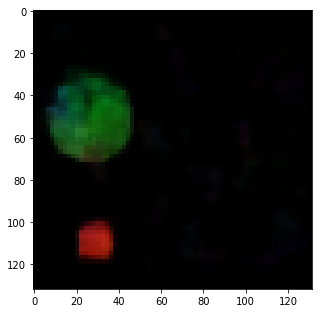

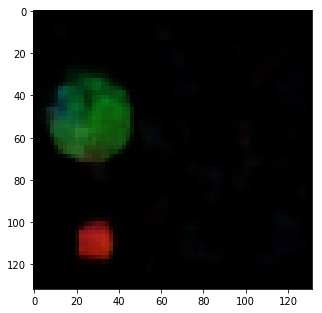

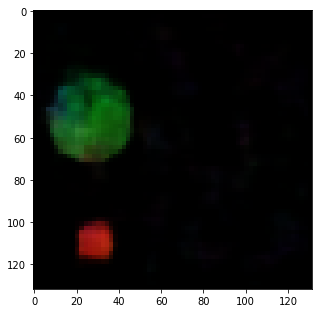

In [156]:
train_with_picture.run()

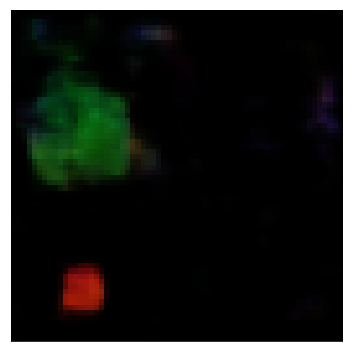

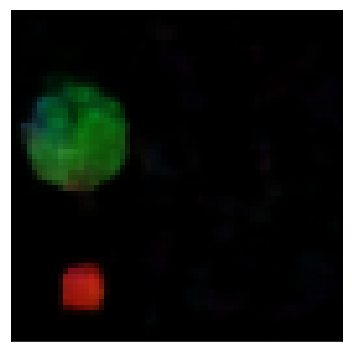

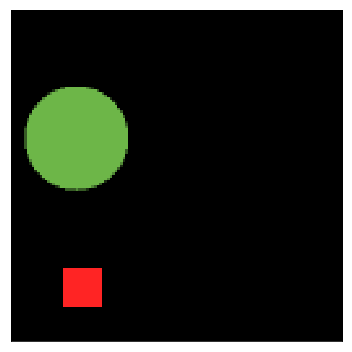

In [157]:
train_with_picture.save_result()

In [122]:
train_with_picture.path_

'experiment_results/02_Apr_2018:16:04:26'

In [158]:
from IPython.core.display import display, HTML
display(HTML(''' <video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video>
<video width="320" height="240" controls loop>
  <source src='{}' type="video/mp4">
</video> '''.format(train_with_picture.path_ +"/fit.mp4",
                    train_with_picture.path_ +"/predict.mp4",
                    train_with_picture.path_ +"/target.mp4")))